# Threshold Analysis: Delta vs SIRS Proportions

This notebook visualizes the relationship between the delta parameter (recovered duration) and the average proportions of Susceptible, Infected, and Recovered fish at equilibrium.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Summary Data

In [18]:
# Read the summary CSV (has multi-level columns)
summary = pd.read_csv("threshold_summary.csv", header=[0, 1], index_col=0)
summary.head()

S_count         I_count         R_count        S_proportion         \
         mean     std    mean     std    mean    std         mean    std   
delta                                                                      
0.1     19.56  12.231   18.24  11.028    2.20  1.841        0.489  0.306   
0.2     18.90  12.474   18.96  11.252    2.14  2.213        0.472  0.312   
0.3     19.46  12.134   18.70  11.061    1.84  1.490        0.486  0.303   
0.4     16.54  11.214   21.20  10.120    2.26  1.805        0.414  0.280   
0.5     20.28  12.347   18.06  11.313    1.66  1.586        0.507  0.309   

      I_proportion        R_proportion         
              mean    std         mean    std  
delta                                          
0.1          0.456  0.276        0.055  0.046  
0.2          0.474  0.281        0.054  0.055  
0.3          0.468  0.277        0.046  0.037  
0.4          0.530  0.253        0.056  0.045  
0.5          0.452  0.283        0.042  0.040

In [19]:
# Extract delta values (from index)
delta_values = summary.index.values

# Extract mean proportions for S, I, R
s_mean = summary[("S_proportion", "mean")].values
i_mean = summary[("I_proportion", "mean")].values
r_mean = summary[("R_proportion", "mean")].values

# Extract std for error bars (optional)
s_std = summary[("S_proportion", "std")].values
i_std = summary[("I_proportion", "std")].values
r_std = summary[("R_proportion", "std")].values

## Bifurcation Analysis: Endemic vs Disease-Free Equilibrium

The key question: **What is the probability that the system settles into an endemic equilibrium (I > 0) vs a disease-free equilibrium (I ≈ 0)?**

Averaging across trials with different outcomes masks this bimodal behavior.

In [20]:
# Load detailed trial-by-trial results
detailed = pd.read_csv("threshold_detailed_results.csv")
print(f"Loaded {len(detailed)} trial results")
print(f"Delta values: {detailed['delta'].nunique()} unique values")
print(f"Trials per delta: {len(detailed) // detailed['delta'].nunique()}")
detailed.head()

Loaded 4000 trial results
Delta values: 80 unique values
Trials per delta: 50


,delta,trial,S_count,I_count,R_count,S_proportion,I_proportion,R_proportion
0,0.1,0,13,23,4,0.325,0.575,0.100
1,0.1,1,12,26,2,0.300,0.650,0.050
2,0.1,2,21,17,2,0.525,0.425,0.050
3,0.1,3,13,24,3,0.325,0.600,0.075
4,0.1,4,40,0,0,1.000,0.000,0.000


In [21]:
# Define threshold for endemic equilibrium (I > 1% means disease persists)
ENDEMIC_THRESHOLD = 0.01

# Calculate probability of endemic equilibrium for each delta
endemic_probs = (
    detailed.groupby("delta")
    .apply(lambda x: (x["I_proportion"] > ENDEMIC_THRESHOLD).sum() / len(x))
    .values
)

# Probability of disease-free equilibrium
disease_free_probs = 1 - endemic_probs

print(
    f"Endemic probability range: {endemic_probs.min():.2%} to {endemic_probs.max():.2%}"
)
print(
    f"Disease-free probability range: {disease_free_probs.min():.2%} to {disease_free_probs.max():.2%}"
)

Endemic probability range: 0.00% to 90.00%
Disease-free probability range: 10.00% to 100.00%


/var/folders/7m/pkkbqhrj14gbpp0s_zb7v9k40000gn/T/ipykernel_42415/1798904716.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["I_proportion"] > ENDEMIC_THRESHOLD).sum() / len(x))


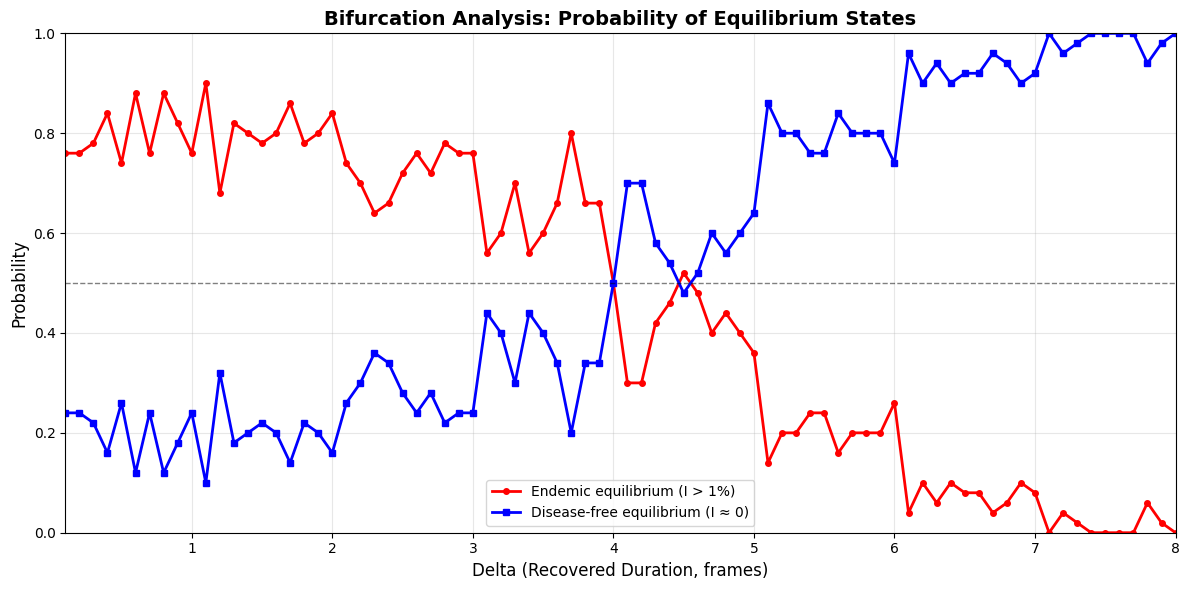

Plot saved to: threshold_bifurcation.png


In [22]:
# Create bifurcation plot
plt.figure(figsize=(12, 6))

# Plot probability of each outcome
plt.plot(
    delta_values,
    endemic_probs,
    "r-",
    linewidth=2,
    marker="o",
    markersize=4,
    label="Endemic equilibrium (I > 1%)",
)
plt.plot(
    delta_values,
    disease_free_probs,
    "b-",
    linewidth=2,
    marker="s",
    markersize=4,
    label="Disease-free equilibrium (I ≈ 0)",
)

# Formatting
plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title(
    "Bifurcation Analysis: Probability of Equilibrium States",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10, loc="best")
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])
plt.ylim(0, 1)

# Add horizontal line at 50% for reference
plt.axhline(y=0.5, color="k", linestyle="--", linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig("threshold_bifurcation.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_bifurcation.png")

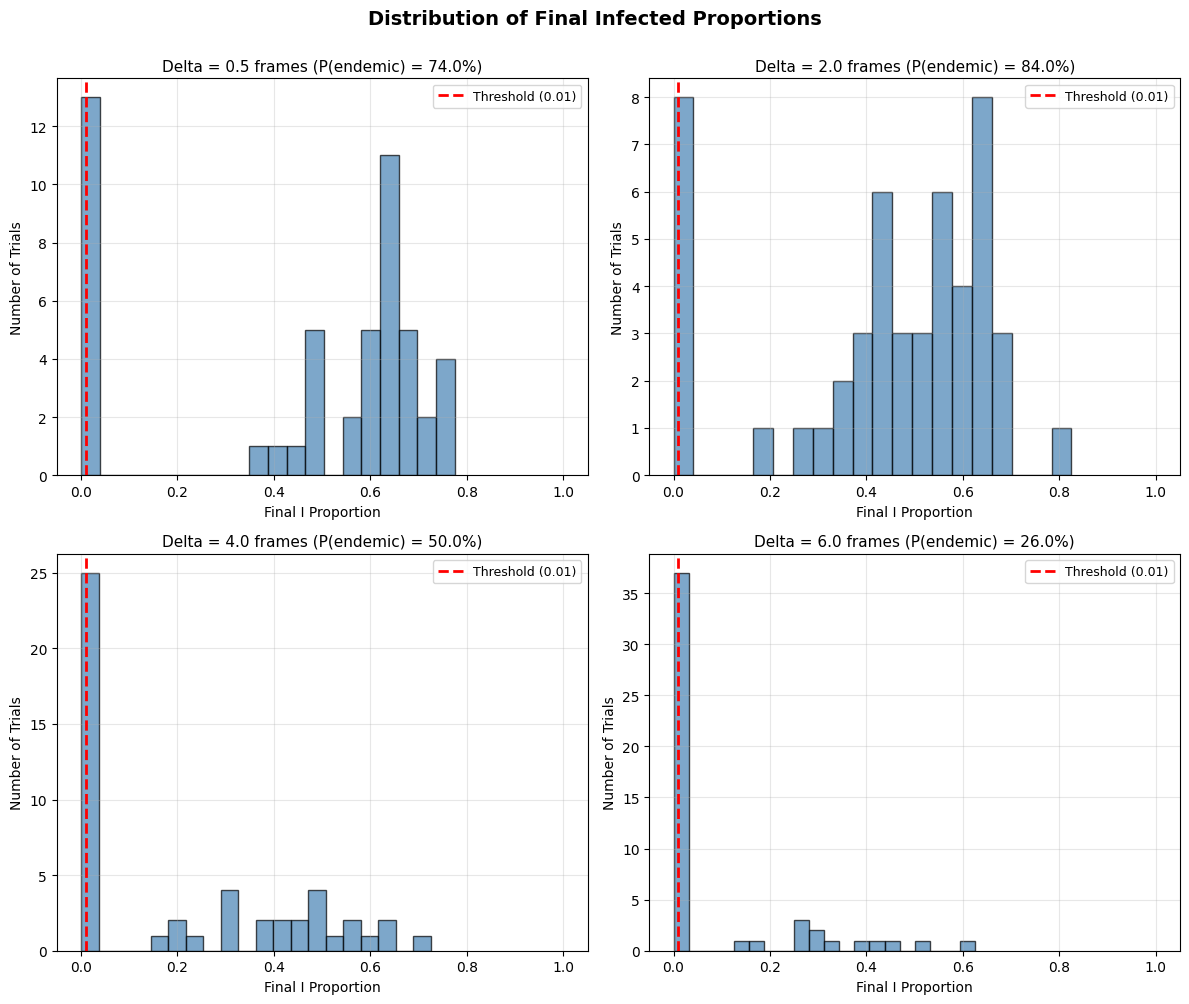

Plot saved to: threshold_distributions.png


In [23]:
# Distribution analysis: Show histograms for selected delta values
key_deltas_dist = [0.5, 2.0, 4.0, 6.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, delta in enumerate(key_deltas_dist):
    ax = axes[i]
    data = detailed[detailed["delta"] == delta]["I_proportion"]

    # Calculate statistics
    n_endemic = (data > ENDEMIC_THRESHOLD).sum()
    n_total = len(data)
    p_endemic = n_endemic / n_total

    ax.hist(data, bins=20, edgecolor="black", alpha=0.7, color="steelblue")
    ax.axvline(
        ENDEMIC_THRESHOLD,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Threshold ({ENDEMIC_THRESHOLD})",
    )
    ax.set_xlabel("Final I Proportion", fontsize=10)
    ax.set_ylabel("Number of Trials", fontsize=10)
    ax.set_title(
        f"Delta = {delta:.1f} frames (P(endemic) = {p_endemic:.1%})", fontsize=11
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)

plt.suptitle(
    "Distribution of Final Infected Proportions", fontsize=14, fontweight="bold", y=1.00
)
plt.tight_layout()
plt.savefig("threshold_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_distributions.png")

In [24]:
# Find critical delta where P(endemic) crosses 50%
crossing_indices = np.where(np.diff(np.sign(endemic_probs - 0.5)))[0]

if len(crossing_indices) > 0:
    idx = crossing_indices[0]
    critical_delta_lower = delta_values[idx]
    critical_delta_upper = delta_values[idx + 1]

    print("=" * 60)
    print("CRITICAL DELTA THRESHOLD ANALYSIS")
    print("=" * 60)
    print(f"\nTransition from endemic to disease-free occurs between:")
    print(
        f"  Delta = {critical_delta_lower:.2f}: P(endemic) = {endemic_probs[idx]:.1%}"
    )
    print(
        f"  Delta = {critical_delta_upper:.2f}: P(endemic) = {endemic_probs[idx+1]:.1%}"
    )

    # Linear interpolation to estimate 50% crossing point
    if endemic_probs[idx] != endemic_probs[idx + 1]:
        critical_delta_est = critical_delta_lower + (0.5 - endemic_probs[idx]) * (
            critical_delta_upper - critical_delta_lower
        ) / (endemic_probs[idx + 1] - endemic_probs[idx])
        print(f"\nEstimated 50% threshold: Delta ≈ {critical_delta_est:.2f} frames")

    # Show a few delta values around the transition
    print(f"\nProbabilities around transition:")
    for i in range(max(0, idx - 2), min(len(delta_values), idx + 4)):
        print(
            f"  Delta = {delta_values[i]:5.1f}: P(endemic) = {endemic_probs[i]:5.1%}, "
            f"P(disease-free) = {disease_free_probs[i]:5.1%}"
        )
else:
    print("No 50% crossing point found in this delta range")
    print(
        f"P(endemic) ranges from {endemic_probs.min():.1%} to {endemic_probs.max():.1%}"
    )

CRITICAL DELTA THRESHOLD ANALYSIS

Transition from endemic to disease-free occurs between:
  Delta = 3.90: P(endemic) = 66.0%
  Delta = 4.00: P(endemic) = 50.0%

Estimated 50% threshold: Delta ≈ 4.00 frames

Probabilities around transition:
  Delta =   3.7: P(endemic) = 80.0%, P(disease-free) = 20.0%
  Delta =   3.8: P(endemic) = 66.0%, P(disease-free) = 34.0%
  Delta =   3.9: P(endemic) = 66.0%, P(disease-free) = 34.0%
  Delta =   4.0: P(endemic) = 50.0%, P(disease-free) = 50.0%
  Delta =   4.1: P(endemic) = 30.0%, P(disease-free) = 70.0%
  Delta =   4.2: P(endemic) = 30.0%, P(disease-free) = 70.0%


## Plot Delta vs SIRS Proportions

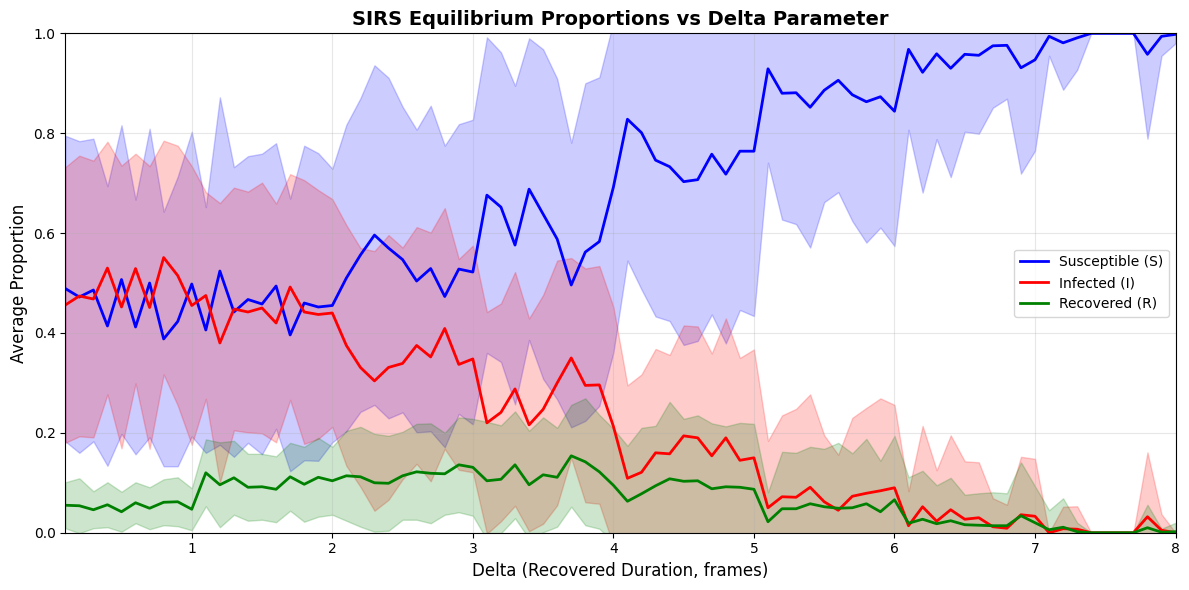

Plot saved to: threshold_delta_vs_sir.png


In [25]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot mean proportions
plt.plot(delta_values, s_mean, "b-", label="Susceptible (S)", linewidth=2)
plt.plot(delta_values, i_mean, "r-", label="Infected (I)", linewidth=2)
plt.plot(delta_values, r_mean, "g-", label="Recovered (R)", linewidth=2)

# Add shaded regions for standard deviation (optional)
plt.fill_between(delta_values, s_mean - s_std, s_mean + s_std, color="blue", alpha=0.2)
plt.fill_between(delta_values, i_mean - i_std, i_mean + i_std, color="red", alpha=0.2)
plt.fill_between(delta_values, r_mean - r_std, r_mean + r_std, color="green", alpha=0.2)

# Labels and formatting
plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Average Proportion", fontsize=12)
plt.title(
    "SIRS Equilibrium Proportions vs Delta Parameter", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("threshold_delta_vs_sir.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_delta_vs_sir.png")

## Focus on Infected Proportion

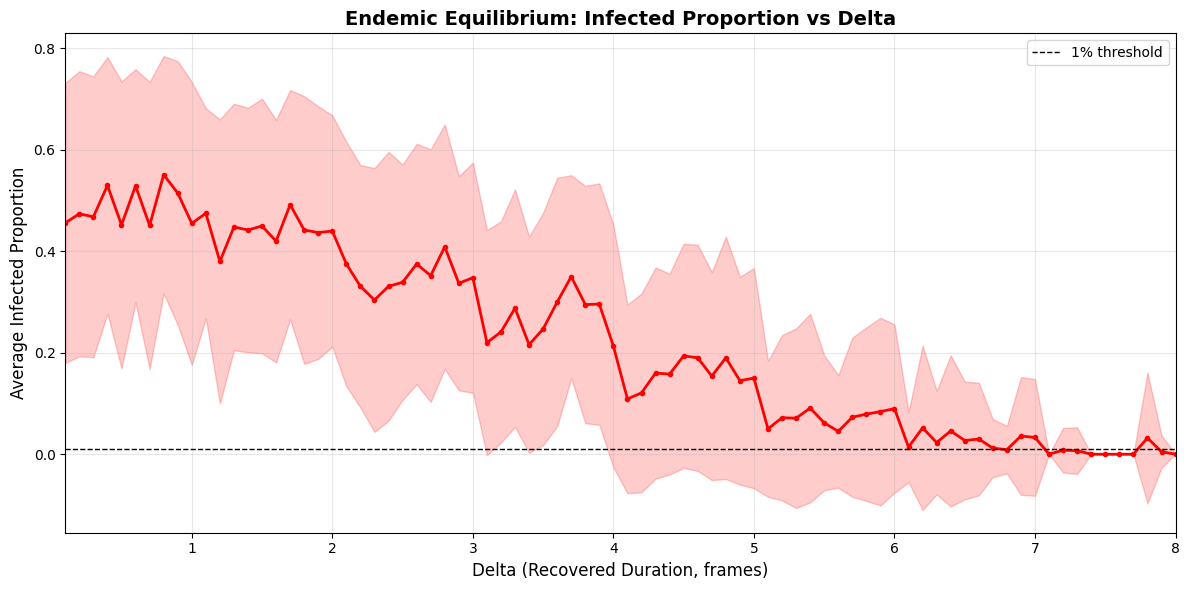

Plot saved to: threshold_infected_vs_delta.png


In [26]:
# Zoom in on infected proportion to identify threshold
plt.figure(figsize=(12, 6))

plt.plot(delta_values, i_mean, "r-", linewidth=2, marker="o", markersize=3)
plt.fill_between(delta_values, i_mean - i_std, i_mean + i_std, color="red", alpha=0.2)

# Add horizontal line at 1% threshold
plt.axhline(y=0.01, color="k", linestyle="--", linewidth=1, label="1% threshold")

plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Average Infected Proportion", fontsize=12)
plt.title(
    "Endemic Equilibrium: Infected Proportion vs Delta", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])

plt.tight_layout()
plt.savefig("threshold_infected_vs_delta.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_infected_vs_delta.png")

## Find Critical Threshold

In [27]:
# Find the first delta value where I > 1%
endemic_mask = i_mean > 0.01
if endemic_mask.any():
    threshold_delta = delta_values[endemic_mask][0]
    print(f"Critical threshold: delta = {threshold_delta:.2f} frames")
    print(f"At this threshold:")
    idx = np.where(delta_values == threshold_delta)[0][0]
    print(f"  S = {s_mean[idx]:.3f} ± {s_std[idx]:.3f}")
    print(f"  I = {i_mean[idx]:.3f} ± {i_std[idx]:.3f}")
    print(f"  R = {r_mean[idx]:.3f} ± {r_std[idx]:.3f}")
else:
    print("No endemic equilibrium found in this delta range")

Critical threshold: delta = 0.10 frames
At this threshold:
  S = 0.489 ± 0.306
  I = 0.456 ± 0.276
  R = 0.055 ± 0.046


## Summary Statistics Table

In [28]:
# Show key delta values
key_deltas = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
key_deltas = [d for d in key_deltas if d in delta_values]

print("Key Delta Values Summary:")
print("=" * 60)
for delta in key_deltas:
    idx = np.where(delta_values == delta)[0][0]
    print(f"Delta = {delta:.1f}:")
    print(f"  S = {s_mean[idx]:.3f} ± {s_std[idx]:.3f}")
    print(f"  I = {i_mean[idx]:.3f} ± {i_std[idx]:.3f}")
    print(f"  R = {r_mean[idx]:.3f} ± {r_std[idx]:.3f}")
    print()

Key Delta Values Summary:
Delta = 0.1:
  S = 0.489 ± 0.306
  I = 0.456 ± 0.276
  R = 0.055 ± 0.046

Delta = 0.5:
  S = 0.507 ± 0.309
  I = 0.452 ± 0.283
  R = 0.042 ± 0.040

Delta = 1.0:
  S = 0.498 ± 0.305
  I = 0.455 ± 0.279
  R = 0.047 ± 0.042

Delta = 2.0:
  S = 0.455 ± 0.274
  I = 0.440 ± 0.228
  R = 0.104 ± 0.068

Delta = 3.0:
  S = 0.522 ± 0.305
  I = 0.348 ± 0.227
  R = 0.131 ± 0.097

Delta = 4.0:
  S = 0.692 ± 0.331
  I = 0.213 ± 0.239
  R = 0.095 ± 0.113

Delta = 5.0:
  S = 0.764 ± 0.330
  I = 0.150 ± 0.217
  R = 0.087 ± 0.131

Delta = 6.0:
  S = 0.844 ± 0.270
  I = 0.090 ± 0.166
  R = 0.066 ± 0.128

Delta = 7.0:
  S = 0.947 ± 0.182
  I = 0.033 ± 0.115
  R = 0.020 ± 0.073

Delta = 8.0:
  S = 0.998 ± 0.018
  I = 0.000 ± 0.000
  R = 0.002 ± 0.018

